In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.style.use('bmh')
from numpy.linalg import matrix_power
import cvxpy as cp
from Utilities.Dynamics_Constraints_Controller import *

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/interpolate/_fitpack_impl.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=21,24 m=400 fp=0.016920 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


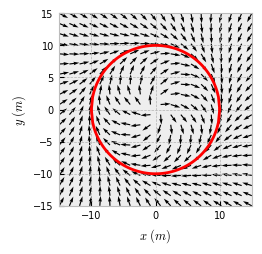

In [2]:
fig, ax= plt.subplots(figsize=(2.5,2.5))
limit = 15
N = 20


xc = np.linspace(-10,10,100)
yc1 = np.sqrt(10**2-xc**2)
yc2 = -np.sqrt(10**2-xc**2)
xx, yy = np.meshgrid(np.linspace(-limit,limit,N),np.linspace(-limit,limit,N))
gamma = np.arctan2(yy, xx)


d = np.sqrt(xx**2 + yy**2)
theta = gamma - np.pi/2 - np.arctan(0.3 * (d-r))
a = 5
beta = 0.3 / (1 + (0.3 * (d-r))**2)
theta_c = theta + V/(d*a) * np.sin(theta - gamma) - beta/a*V*np.cos(theta-gamma)
Fx = np.cos(theta_c) 
Fy = np.sin(theta_c)

ax.quiver(xx, yy, Fx , Fy , color='k', width=0.006, zorder=1, scale=10, scale_units = 'inches')
ax.plot(xc,yc1,'r')
ax.plot(xc,yc2,'r')
ax.axis('equal')
ax.set_xlim((-limit,limit))
ax.set_ylim((-limit,limit))
ax.set_xlabel('$x\,\, (m)$', fontsize=9)
ax.set_ylabel('$y\,\, (m)$', fontsize=9)
fig.savefig('Figures/VectorField.pdf',bbox_inches ="tight")

In [3]:
limit = 15


circle1 = plt.Circle((xs[0], ys[0]), rs[0], facecolor = 'blue')
circle2 = plt.Circle((xs[1], ys[1]), rs[1], color='blue')
circle3 = plt.Circle((xs[2], ys[2]), rs[2], color='blue')

xc = np.linspace(-10,10,100)
yc1 = np.sqrt(10**2-xc**2)
yc2 = -np.sqrt(10**2-xc**2)
xx, yy = np.meshgrid(np.linspace(-limit,limit,N),np.linspace(-limit,limit,N))
gamma = np.arctan2(yy, xx)
r=10.0
d = np.sqrt(xx**2 + yy**2)
theta = gamma - np.pi/2 - np.arctan(0.3 * (d-r))
a = 5
beta = 0.3 / (1 + (0.3 * (d-r))**2)
theta_c = theta + V/(d*a) * np.sin(theta - gamma) - beta/a*V*np.cos(theta-gamma)
theta_c = theta
Fx = np.cos(theta_c) 
Fy = np.sin(theta_c)

theta_star = np.full((N,N),np.nan)
I = np.full(Fx.shape, True)
for i in range(N):
    for j in range(N):
        x = xx[i,j]
        y = yy[i,j]
        u = cp.Variable((2,))
        objective = cp.Minimize(cp.quad_form(u - np.array([Fx[i,j],Fy[i,j]]), np.diag(np.ones(2,))))
        Del_h_mat = np.full((3,2), 0.0)
        h_vec = np.full((3,), 0.0)
        for nn in range(3):
            h_vec[nn] = (x-xs[nn]) ** 2 + (y-ys[nn]) ** 2 - rs[nn] ** 2
            if h_vec[nn]<=0:
                I[i,j] = False
            Del_h_mat[nn,:] = 2 * np.array([x-xs[nn], y-ys[nn]])
        constraints = [Del_h_mat @ u >= -0.05*h_vec]
        prob = cp.Problem(objective,constraints)#)#, constraints)
        # The optimal objective value is returned by `prob.solve()`.
        result = prob.solve()
        # The optimal value for x is stored in `x.value`.
        uStar = u.value
        theta_star[i, j] = np.arctan2(uStar[1],uStar[0])


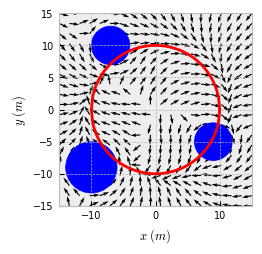

In [4]:
fig, ax= plt.subplots(figsize=(2.5,2.5))
Fx = np.cos(theta_star) 
Fy = np.sin(theta_star)
I = np.full(Fx.shape, True)
ax.quiver(xx[I], yy[I], Fx[I] , Fy[I] , color='k', width=0.006, zorder=1, scale=10, scale_units = 'inches')
ax.plot(xc,yc1,'r')
ax.plot(xc,yc2,'r')
ax.axis('equal')
#ax.set_xlim((-9,11))
#ax.set_ylim((-5,15))
ax.set_xlim((-limit,limit))
ax.set_ylim((-limit,limit))
ax.set_xlabel('$x\,\, (m)$', fontsize=9)
ax.set_ylabel('$y\,\, (m)$', fontsize=9)
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)
fig.savefig('Figures/Obstacles.pdf',bbox_inches ="tight")

In [5]:
np.save('Utilities/ControllerData/KlookuptableX.npy', xx)
np.save('Utilities/ControllerData/KlookuptableY.npy', yy)
np.save('Utilities/ControllerData/KlookuptableU.npy', theta_star)